Haussdorf Metrics and Loss Function
====
Using the Haussdorf distance we can hopefully improve our image segmentation algorithms.

The Haussdorf distance between two objects is defined as the maximum shortest distance from one object to another: this isn't a very helpful definition, so a diagram is helpful:

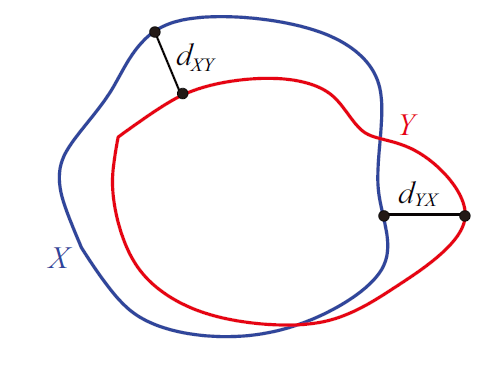

In [1]:
from PIL import Image

Image.open("img/haussdorf.png")

If we choose any point on X, we can find the shortest distance to Y; by choosing the right point on X, we can find the largest such distance ($d_{XY}$).
Similarly, we can find the greatest shortest distance from Y to X ($d_{YX}$).
The Haussdorf distance is defined as the greatest of these two distances.

It is a useful metric because it encapsulates our intuitive idea of "closeness".

For objects in 2d, we can work out the Haussdorf distance...

In [83]:
"""
Create two binary images, x and y, and calculate the Hausdorff distance between them.

"""
from typing import Union, Iterable

import numpy as np
from scipy import ndimage
from skimage import metrics
import matplotlib.pyplot as plt

IMG_SIZE = (256, 192)
RNG = np.random.default_rng(seed=0)


def gaussian_image(
    *, centre: tuple[int, int], sigma: Union[float, Iterable[float]]
) -> np.ndarray:
    """
    Binary image generated from a Gaussian, centred on the image centre

    """
    # Zeros with a 1 in the middle
    arr = np.zeros(IMG_SIZE)
    arr[centre] = 1

    # Apply a Gaussian filter to this 1 to spread it out
    arr = ndimage.gaussian_filter(arr, sigma=sigma)

    # Scale
    arr = arr / arr.max()
    arr = arr > 0.5

    return arr.astype(int)


# Define the two images
x_centre = (IMG_SIZE[0] // 3, IMG_SIZE[1] // 3)
x = gaussian_image(centre=x_centre, sigma=IMG_SIZE[0] // 8)

y_centre = (IMG_SIZE[0] // 2, 2 * IMG_SIZE[1] // 5)
y = gaussian_image(centre=y_centre, sigma=[IMG_SIZE[0] // 4, IMG_SIZE[1] // 7])

# Find the Hausdorff distance between them
distance = metrics.hausdorff_distance(x, y)

# For plotting, we'll also want to find the points that this corresponds to
haussdorf_points = metrics.hausdorff_pair(x, y)

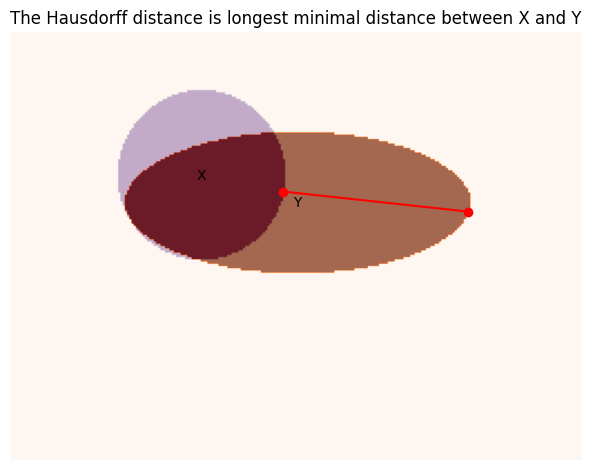

In [84]:
fig, axis = plt.subplots(1, 1)
axis.set_aspect("equal")

axis.imshow(x.T, alpha=1.0, origin="upper", cmap="Purples")
axis.imshow(y.T, alpha=0.7, origin="upper", cmap="Oranges")

axis.text(*x_centre, "X", ha="center", va="center", color="black")
axis.text(*y_centre, "Y", ha="center", va="center", color="black")

hausdorff_x, hausdorff_y = zip(*haussdorf_points)
axis.plot(hausdorff_x, hausdorff_y, "ro-")

axis.set_title(f"The Hausdorff distance is longest minimal distance between X and Y")

axis.axis("off")

fig.tight_layout()

A complication for segmentation problems
----
Unfortunately, when we train a model to segment an image it does not give us a prediction of a neatly segmented object with a hard boundary - instead, it gives us a floating point number for each pixel that tells us how confident it is about its prediction.

This makes training the model easier - if it were to give a hard prediction, it would likely be unable to learn as the loss function would have zero gradients, with sharp steps in the loss as it guesses the correct position of the object.

It also, however, makes evaluating the Hausdorff distance more difficult as this is only defined for objects with hard boundaries:

In [94]:
"""
Show a fuzzy prediction against the hard ground truth

"""
fuzzy_x = ndimage.gaussian_filter(x.astype(np.float32), sigma=IMG_SIZE[0] // 64)
print(np.unique(fuzzy_x))

[0.0000000e+00 1.1194874e-09 4.0689434e-09 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]


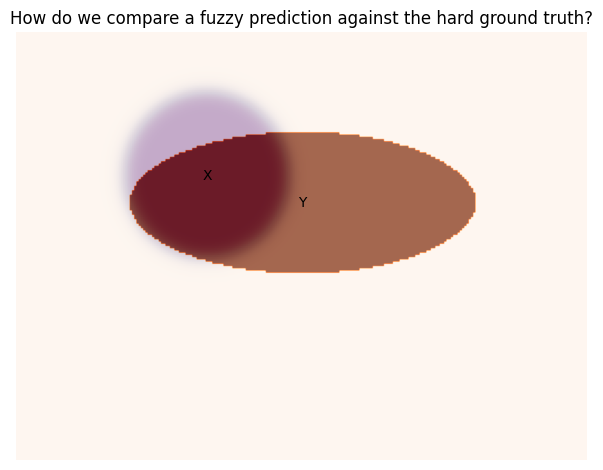

In [100]:
fig, axis = plt.subplots(1, 1)
axis.set_aspect("equal")

axis.imshow(fuzzy_x.T, alpha=1.0, origin="upper", cmap="Purples")
axis.imshow(y.T, alpha=0.7, origin="upper", cmap="Oranges")

axis.text(*x_centre, "X", ha="center", va="center", color="black")
axis.text(*y_centre, "Y", ha="center", va="center", color="black")

axis.set_title("How do we compare a fuzzy prediction against the hard ground truth?")

axis.axis("off")
fig.tight_layout()